In [8]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

train_dir = "데이터셋/한국인 감정인식을 위한 복합 영상/최종 데이터셋/train"
val_dir = "데이터셋/한국인 감정인식을 위한 복합 영상/최종 데이터셋/val"
test_dir = "데이터셋/한국인 감정인식을 위한 복합 영상/최종 데이터셋/test"
 
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    color_mode="grayscale")

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    color_mode="grayscale")

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    color_mode="grayscale")

Found 58487 images belonging to 5 classes.
Found 12533 images belonging to 5 classes.
Found 12534 images belonging to 5 classes.


In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [10]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential

model = Sequential()

model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_6 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 128)      

In [11]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_path = "v2_final.hdf5"
checkpoint_cb = ModelCheckpoint(checkpoint_path, verbose=1, save_best_only=True,monitor='val_loss')
early_stop_cb = EarlyStopping(patience=5,restore_best_weights=True)

In [12]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[checkpoint_cb,early_stop_cb])

Epoch 1/50
1826/1827 [============================>.] - ETA: 0s - loss: 0.8238 - accuracy: 0.6877
Epoch 1: val_loss improved from inf to 0.56548, saving model to v2_final.hdf5
1827/1827 [==============================] - 128s 69ms/step - loss: 0.8237 - accuracy: 0.6878 - val_loss: 0.5655 - val_accuracy: 0.7996
Epoch 2/50
1827/1827 [==============================] - ETA: 0s - loss: 0.5484 - accuracy: 0.8014
Epoch 2: val_loss improved from 0.56548 to 0.49630, saving model to v2_final.hdf5
1827/1827 [==============================] - 77s 42ms/step - loss: 0.5484 - accuracy: 0.8014 - val_loss: 0.4963 - val_accuracy: 0.8203
Epoch 3/50
1827/1827 [==============================] - ETA: 0s - loss: 0.4819 - accuracy: 0.8300
Epoch 3: val_loss improved from 0.49630 to 0.41341, saving model to v2_final.hdf5
1827/1827 [==============================] - 77s 42ms/step - loss: 0.4819 - accuracy: 0.8300 - val_loss: 0.4134 - val_accuracy: 0.8550
Epoch 4/50
1827/1827 [==============================] - ET

In [13]:
model.evaluate(test_generator)


392/392 [==============================] - 22s 55ms/step - loss: 0.2965 - accuracy: 0.8982


[0.2965281009674072, 0.8981968760490417]

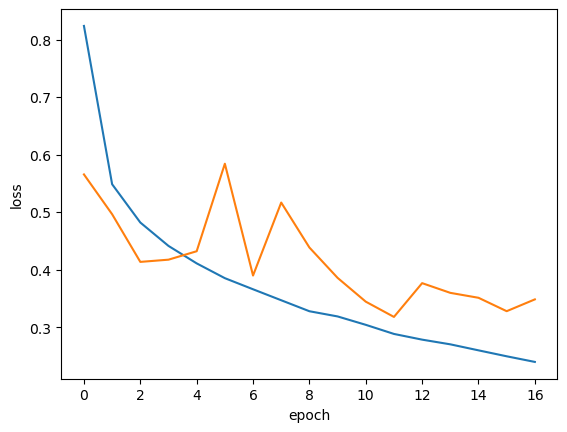

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")

plt.show()

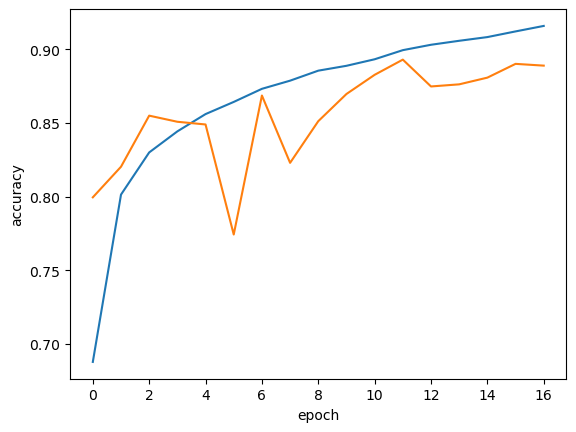

In [15]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

392/392 [==============================] - 13s 32ms/step


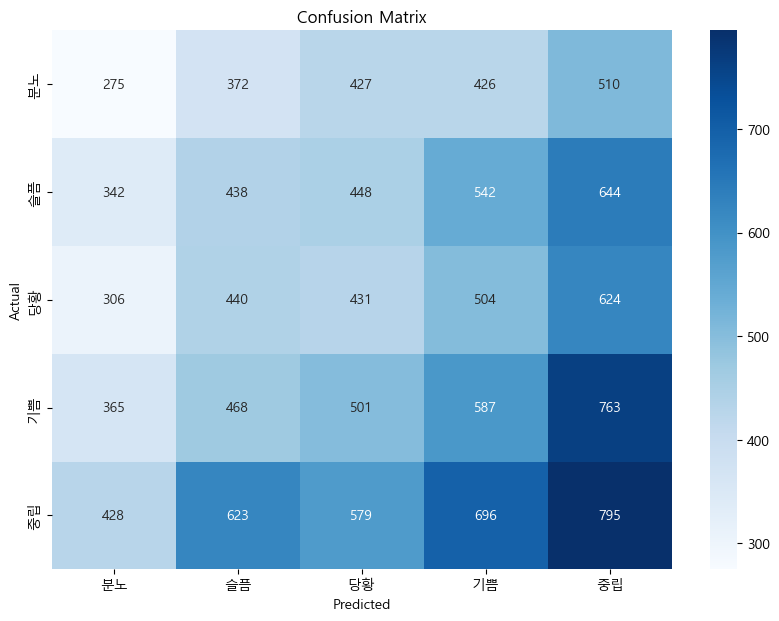

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
predictions = model.predict(test_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_generator.classes
emotions_korean = ["분노", "슬픔", "당황", "기쁨", "중립"]

cm = confusion_matrix(y_test, y_pred)
plt.rcParams['font.family'] = 'Malgun Gothic'

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions_korean, yticklabels=emotions_korean)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()